# Phase II: Data Curation, Exploratory Analysis and Plotting
## What makes someone good at chess?

- Sandeep Salwan
- Andrew Fielding
- QuangVinh Tran

## Project Goal:

Chess is a global strategy game played by all, from children to the elderly, with countless openings, tactics, and playstyles that all influence the outcome of the match. Many dedicated chess players hone in on these aspects while reviewing past games or studying the professionals in search of improvement. However, what if the strategies employed are not the best fit for a given rank and/or playstyle? With the wealth of data available by APIs such as Lichess and Stockfish API, this project seeks to understand the effectiveness of various openings, playstyles (such as aggressive vs. passive), and common tactics at various ranks to provide users of all skill levels with applicable information to help improve their game. Additionally, with the rise of chess.com, chess can be played online with players being matched to those of similar ranking; however, not every match will be evenly set resulting in a potential skill advantage to the higher-ranked player. Our goal is to help players understand what factors most significantly impact their chances of victory, and to help them understand how the details of a match might effect its outcome. This study aims to explore several key questions:
1. Which chess openings and playstyles lead to higher win percentages across different rank levels?
2. How does the rating differential impact the outcome of a match?
3. Given several characteristics about a game of chess, how likely is each player to win? Who is expected to be the victor? 
4. How does the differential between the rankings of the competitors in a game impact the length of the game?

## Pipeline Overview:

**1. Data Collection** - Fetch player data from the **Lichess API**: usernames, game details, ratings, moves, and openings.

**2. Data Processing** - Clean up the raw data: extract openings, check game outcomes, calculate rating differences, and handle missing info.

**3. Data Export** - Save the cleaned data into a **CSV** for easy manipulation, analysis, and reporting.

**4. Data Analysis** - Manipulate the data as necessary, building dataframes for different visualizations. Look at win rates: figure out which **openings** and **playstyles** work best for different colors at different ranks, check out how **rating gaps** affect match results, see which **colors** typically win more frequently, see how **move count** (game length) might be impacted by the details of a game.

### Data Collection:

#### 0. Imports

In [1]:
# Install required libraries
%pip install berserk pandas chess stockfish matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [17]:
import berserk
import pandas as pd
import chess
import chess.polyglot
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snsC
import warnings
import plotly.express as px
warnings.filterwarnings('ignore')

In [ ]:
# ---------------------------
# Step 1: Set Token
# ---------------------------

token = ""  # Your token here export LICHESS_API_TOKEN="..."

if not token:
    raise ValueError("No token.")


#### 2. Query generation API Code

In [ ]:
# ---------------------------
# Step 2: Init Client
# ---------------------------

session = berserk.TokenSession(token)
client = berserk.Client(session=session)


In [ ]:
# ---------------------------
# Step 3: Fetch Players
# ---------------------------

def get_top_players(perf='blitz', cnt=100):
    try:
        lb = client.users.get_leaderboard(perf_type=perf, count=cnt)  # leaderboard
        return [user['username'] for user in lb]  # names
    except berserk.exceptions.ResponseError as e:
        print(f"Error: {e}")
        return []  # return empty if error

# perf types to fetch
perf_types = {'blitz': 100, 'bullet': 100, 'rapid': 100, 'classical': 100}

# collect all usernames
all_users = set()
for perf, cnt in perf_types.items():
    users = get_top_players(perf, cnt)
    all_users.update(users)
    print(f"Fetched {len(users)} {perf}")

print(f"Total: {len(all_users)} users")


In [ ]:
# ---------------------------
# Step 4: Helper Functions
# ---------------------------

# retry fetching games
def get_games(username, max_games, retries=3, delay=5):
    for attempt in range(retries):
        try:
            games = client.games.export_by_player(
                username,
                max=max_games,
                perf_type='classical',  # Ensure 'classical' is correctly specified
                moves=True,
                pgn_in_json=False,
                clocks=False,
                evals=False,
                opening=True,
                as_pgn=False
            )
            return list(games)  # success
        except berserk.exceptions.ResponseError as e:
            if e.status_code == 429:  # limit hit
                print(f"Wait {delay} sec...")
                time.sleep(delay)
            else:
                print(f"Error: {e}. Retry {attempt + 1}")
                time.sleep(delay)
        except Exception as e:
            print(f"Error: {e}. Retry {attempt + 1}")
            time.sleep(delay)
    return []  # fail

# determine opening
def get_opening(moves):
    board = chess.Board()
    opening_name = 'Unknown'
    eco_code = 'Unknown'

    for move_uci in moves.split()[:20]:  # Limit to first 20 moves
        try:
            move = chess.Move.from_uci(move_uci)
            if move not in board.legal_moves:
                break  # Illegal move
            board.push(move)
            #Using python-chess's eco database to get the opening names
            current_opening = chess.polyglot.opening_name(board)
            if current_opening != "Unknown Opening":
                opening_name = current_opening
                eco_code = 'N/A'  # if unknown we cant use eco 
                break
        except Exception as e:
            print(f"Error parsing move {move_uci}: {e}")
            break  # Invalid move

    opening = f"{eco_code}: {opening_name}"
    return opening


In [ ]:
# ---------------------------
# Step 5: Fetch & Process Games
# ---------------------------

max_games = 100
sleep_time = 1  # seconds to wait

all_data = []  # store game data
print("Fetching games...")

for idx, user in enumerate(all_users):
    print(f"User {idx + 1}: {user}")
    games = get_games(user, max_games)
    print(f"Got {len(games)} games.")

    for game in games:
        try:
            white = game['players']['white'].get('user', {}).get('name', 'Anon')
            white_rating = game['players']['white'].get('rating')
            black = game['players']['black'].get('user', {}).get('name', 'Anon')
            black_rating = game['players']['black'].get('rating')

            game_id = game['id']
            link = f"https://lichess.org/{game_id}"

            opening = game.get('opening', {}).get('name', 'Unknown')
            moves = game.get('moves', '')
            if opening == 'Unknown':
                opening = get_opening(moves)

            winner = game.get('winner', 'draw')
            move_count = len(moves.split())

            all_data.append({
                'game_id': game_id,
                'white': white,
                'white_rating': white_rating,
                'black': black,
                'black_rating': black_rating,
                'opening': opening,
                'winner': winner,
                'moves': move_count,
                'link': link
            })
        except Exception as e:
            print(f"Error in {game.get('id', 'Unknown')}: {e}")

    time.sleep(sleep_time)  # respect limits

print(f"Total games: {len(all_data)}")


In [ ]:
# ---------------------------
# Step 6: Create DataFrame
# ---------------------------
#after creating the DataFrame, drop games with unknown openings
df_cleaned = df[df['opening'] != 'Unknown: Unknown']
print(f"Dropped {df.shape[0] - df_cleaned.shape[0]} games with unknown openings.")
df_cleaned.to_csv('lichess_games_data.csv', index=False)
print("Exported cleaned data to CSV.")

df = pd.DataFrame(all_data)
print(df.head())  # show first rows


In [ ]:
# ---------------------------
# Step 7: Export CSV
# ---------------------------

df.to_csv('lichess_games_data.csv', index=False)
print("Exported to CSV.")


### Data processing: 

In [18]:
df = pd.read_csv("lichess_games_data.csv")
df.head(5)

,game_id,white_player,white_rating,black_player,black_rating,opening,winner,move_count,link
0,vFnweJqm,pavaobjazevic,2286.0,Ali_Oezcelik,2006.0,A13: English Opening: Agincourt Defense,white,133,https://lichess.org/vFnweJqm
1,Jo94KKT6,Sonia111,1954.0,pavaobjazevic,2284.0,A05: Zukertort Opening: Nimzo-Larsen Variation,black,102,https://lichess.org/Jo94KKT6
2,SMfjdjMS,pavaobjazevic,2287.0,sandeepsmit11,2020.0,D35: Queen's Gambit Declined: Exchange Variati...,black,66,https://lichess.org/SMfjdjMS
3,tE7AS6Yr,superhero_13,1898.0,pavaobjazevic,2286.0,"C54: Italian Game: Classical Variation, Greco ...",black,28,https://lichess.org/tE7AS6Yr
4,mJVHivZ5,pavaobjazevic,2295.0,PinkSuccession,1898.0,A20: English Opening: King's English Variation,black,52,https://lichess.org/mJVHivZ5


#### Build helper functions for data processing:

In [19]:
# clean openings
def clean_opening(name):
    for d in [":", " |", " #", " Accepted", " Declined", " Refused"]:
        name = name.split(d)[0]
    return name

# categorize ratings into buckets
def rate_cat(rate):
    if rate < 1200: return 'Below 1200'
    elif rate < 1400: return '1200-1399'
    elif rate < 1600: return '1400-1599'
    elif rate < 1800: return '1600-1799'
    elif rate < 2000: return '1800-1999'
    elif rate < 2200: return '2000-2199'
    elif rate < 2400: return '2200-2399'
    else: return '2400+'
    
def calc_diff(df, col1, col2, col3, cond1, cond2):
    ''' calculates the difference between col1 and col2 modifies col3 based on given conditions
    Args:
        df (dataframe)- dataframe of interest
        col1 (string)- column name for differential calculation
        col2 (string)- column name for differential calculation
        col3 (string)- column name to be modified
        cond1 (string)- string to match for col2
        cond2 (string)- string to match for col2

    Returns:
        df (dataframe)- dataframe with updated col3
    '''
    for i in range(len(df)):
        game = df.loc[i]
        
        # Check conditions and assign values using .loc
        # If white's rating is higher and white won, no change to its differential value
        if game[col1] > 0 and game[col2] == cond1:
            df.loc[i, col3] = 1
        # If black's rating is higher and black won, turn the differential to positive
        elif game[col1] < 0 and game[col2] == cond2:
            df.loc[i, col3] = 1
            df.loc[i, col1] = -df.loc[i, col1] 
    return df

def new_line(item):
    """ splits a string at spaces and adds a new line character after the first word in the resultant list of strings
    
    Args: 
        item (str): any string, for our purposes it will be the name of a chess opening
        
    Returns: 
        new_item (str): the same string, but with a new line charactr between the first and second word
    """
    # split the string
    split_item = item.split(' ')
    
    # add the new line character
    split_item.insert(1, ' \n')
    
    # rebuild the string
    new_item = ' '.join(split_item)
    
    return new_item

#### Feature engineering and primary dataframe organization

In [20]:
# avg rating per game
df['avg_rating'] = (df['white_rating'] + df['black_rating']) / 2

# apply rating category to the avg rating
df['rating_cat'] = df['avg_rating'].apply(rate_cat)

# build a column with the opening name and first variation
df['opening_name'] = df['opening'].str.extract(r':\s*(.*)')[0]
df['opening_name'] = df['opening_name'].str.split(',').str[0].str.strip()

# build a column name with the opening name
df['clean_opening'] = df['opening_name'].apply(clean_opening)

# replace specific names in the clean opening column
df['clean_opening'].replace({
    "King's Pawn Game": "King's Pawn",
    "Queen's Pawn Game": "Queen's Pawn",
    "Ware Defense": "Ware Opening"
}, inplace=True)

# calculating the rating differential and adding to the df
df['rating_diff'] = df['white_rating'] - df['black_rating']

# edits values in the differential column to reflect black victories (eg flip sign of white-black base differential when black wins)
for i in range(len(df)):
    if df['winner'][i] == 'white':
        df['rating_diff'][i] = df['rating_diff'][i]
    elif df['winner'][i] == 'black':
        df['rating_diff'][i] = df['rating_diff'][i] * -1
    
    # fills the rating diff column with a nan value for draws
    else: 
        df['rating_diff'][i] = np.nan
        
# reorder the columns in the dataframe
df = df[['game_id', 'white_player', 'black_player', 'white_rating', 'black_rating', 'avg_rating', 'rating_cat', 
         'winner', 'rating_diff', 'opening', 'opening_name', 'clean_opening', 'move_count', 'link']]

df.head()

,game_id,white_player,black_player,white_rating,black_rating,avg_rating,rating_cat,winner,rating_diff,opening,opening_name,clean_opening,move_count,link
0,vFnweJqm,pavaobjazevic,Ali_Oezcelik,2286.0,2006.0,2146.0,2000-2199,white,280.0,A13: English Opening: Agincourt Defense,English Opening: Agincourt Defense,English Opening,133,https://lichess.org/vFnweJqm
1,Jo94KKT6,Sonia111,pavaobjazevic,1954.0,2284.0,2119.0,2000-2199,black,330.0,A05: Zukertort Opening: Nimzo-Larsen Variation,Zukertort Opening: Nimzo-Larsen Variation,Zukertort Opening,102,https://lichess.org/Jo94KKT6
2,SMfjdjMS,pavaobjazevic,sandeepsmit11,2287.0,2020.0,2153.5,2000-2199,black,-267.0,D35: Queen's Gambit Declined: Exchange Variati...,Queen's Gambit Declined: Exchange Variation,Queen's Gambit,66,https://lichess.org/SMfjdjMS
3,tE7AS6Yr,superhero_13,pavaobjazevic,1898.0,2286.0,2092.0,2000-2199,black,388.0,"C54: Italian Game: Classical Variation, Greco ...",Italian Game: Classical Variation,Italian Game,28,https://lichess.org/tE7AS6Yr
4,mJVHivZ5,pavaobjazevic,PinkSuccession,2295.0,1898.0,2096.5,2000-2199,black,-397.0,A20: English Opening: King's English Variation,English Opening: King's English Variation,English Opening,52,https://lichess.org/mJVHivZ5


## Data Visualization ##

### Viz 1: ###

We don't want to analyze every opening. There are over 100 unique general openings in the dataset, many
of which are not frequently used. This first viz builds a heatmap of which openings are used most frequently
by each rating category so we can see how many openings are really relevant for analysis.

#### Data manipulation:

In [21]:
# filter openings used in less than 100 games 
filtered_df = df.groupby("clean_opening").filter(lambda g: len(g) >= 100)

# create a pivot table using the filtered data to see how many times each opening is used in each rating category
pivot = filtered_df.groupby(["rating_cat", "clean_opening"]).size().unstack().fillna(0)

#### Plot creation:

In [22]:
if pivot.empty:
    print("No datainfo")
else:
    # heatmap plot
    plt.figure(figsize=(30, 15))
    sns.heatmap(
        pivot.apply(lambda row: row / row.sum() if row.sum() != 0 else row, axis=1),
        cmap='YlOrBr', annot=True, linewidths=0.005, linecolor='black',
        annot_kws={"fontsize": 14}, fmt='.2f', cbar=False
    )

    plt.title('Openings by Ratings', fontsize=20)
    plt.xlabel("Openings", fontsize=16)
    plt.ylabel("Rating Brackets", fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12, rotation=45)
    plt.tight_layout()
    plt.show()

NameError: name 'sns' is not defined

<Figure size 2160x1080 with 0 Axes>

### Viz 2: ###

Based on the results of viz 1, it looks like about 10 main openings are used fairly widely across rating categories. It therefore seems like it would be reasonable for us to analyze the top 10 openings that are most frequently used. Our first idea was to examine the relative win rate of each of these openings (eg the proportion of games played where white wins vs. where black wins vs. where the players draw) based on rating categories. This viz builds subplots for each rating category, with each subplot showing stacked bar charts of win/draw rates for each of the top 10 openings for every rating category. 

#### Data manipulation:

In [23]:
# determine the top 10 most frequently used openings
top_openings = df['clean_opening'].value_counts().nlargest(10).index

# build a new dataframe that only includes games using the top 10 openings
df_top_openings = df[df['clean_opening'].isin(top_openings)]

# group by rating, opening, winner
grouped = df_top_openings.groupby(['rating_cat', 'clean_opening', 'winner']).size().reset_index(name='count')

# pivot table for winners
pivot_df = grouped.pivot_table(index=['rating_cat', 'clean_opening'], columns='winner', values='count', fill_value=0)

# win percentages
pivot_df['total_games'] = pivot_df.sum(axis=1)
pivot_df['white_win_pct'] = (pivot_df.get('white', 0) / pivot_df['total_games']) * 100
pivot_df['black_win_pct'] = (pivot_df.get('black', 0) / pivot_df['total_games']) * 100
pivot_df['draw_pct'] = (pivot_df.get('draw', 0) / pivot_df['total_games']) * 100

# reset index for plotting
pivot_df = pivot_df.reset_index()

# groups the df by rating and orders the rows within each rating alphabetically by name of opening (for uniformity)
alpha_pivot_df = pivot_df.sort_values(['rating_cat', 'clean_opening'])

alpha_pivot_df.head(10)

winner,rating_cat,clean_opening,black,draw,white,total_games,white_win_pct,black_win_pct,draw_pct
0,1200-1399,Caro-Kann Defense,3,0,5,8,62.500000,37.500000,0.00
1,1200-1399,English Opening,0,0,1,1,100.000000,0.000000,0.00
2,1200-1399,French Defense,2,0,4,6,66.666667,33.333333,0.00
3,1200-1399,Indian Defense,3,0,0,3,0.000000,100.000000,0.00
4,1200-1399,Italian Game,4,0,2,6,33.333333,66.666667,0.00
5,1200-1399,Queen's Gambit,2,0,7,9,77.777778,22.222222,0.00
6,1200-1399,Queen's Pawn,1,0,6,7,85.714286,14.285714,0.00
7,1200-1399,Ruy Lopez,1,0,1,2,50.000000,50.000000,0.00
8,1200-1399,Sicilian Defense,6,0,3,9,33.333333,66.666667,0.00
9,1400-1599,Caro-Kann Defense,47,7,26,80,32.500000,58.750000,8.75


#### Plot creation: 

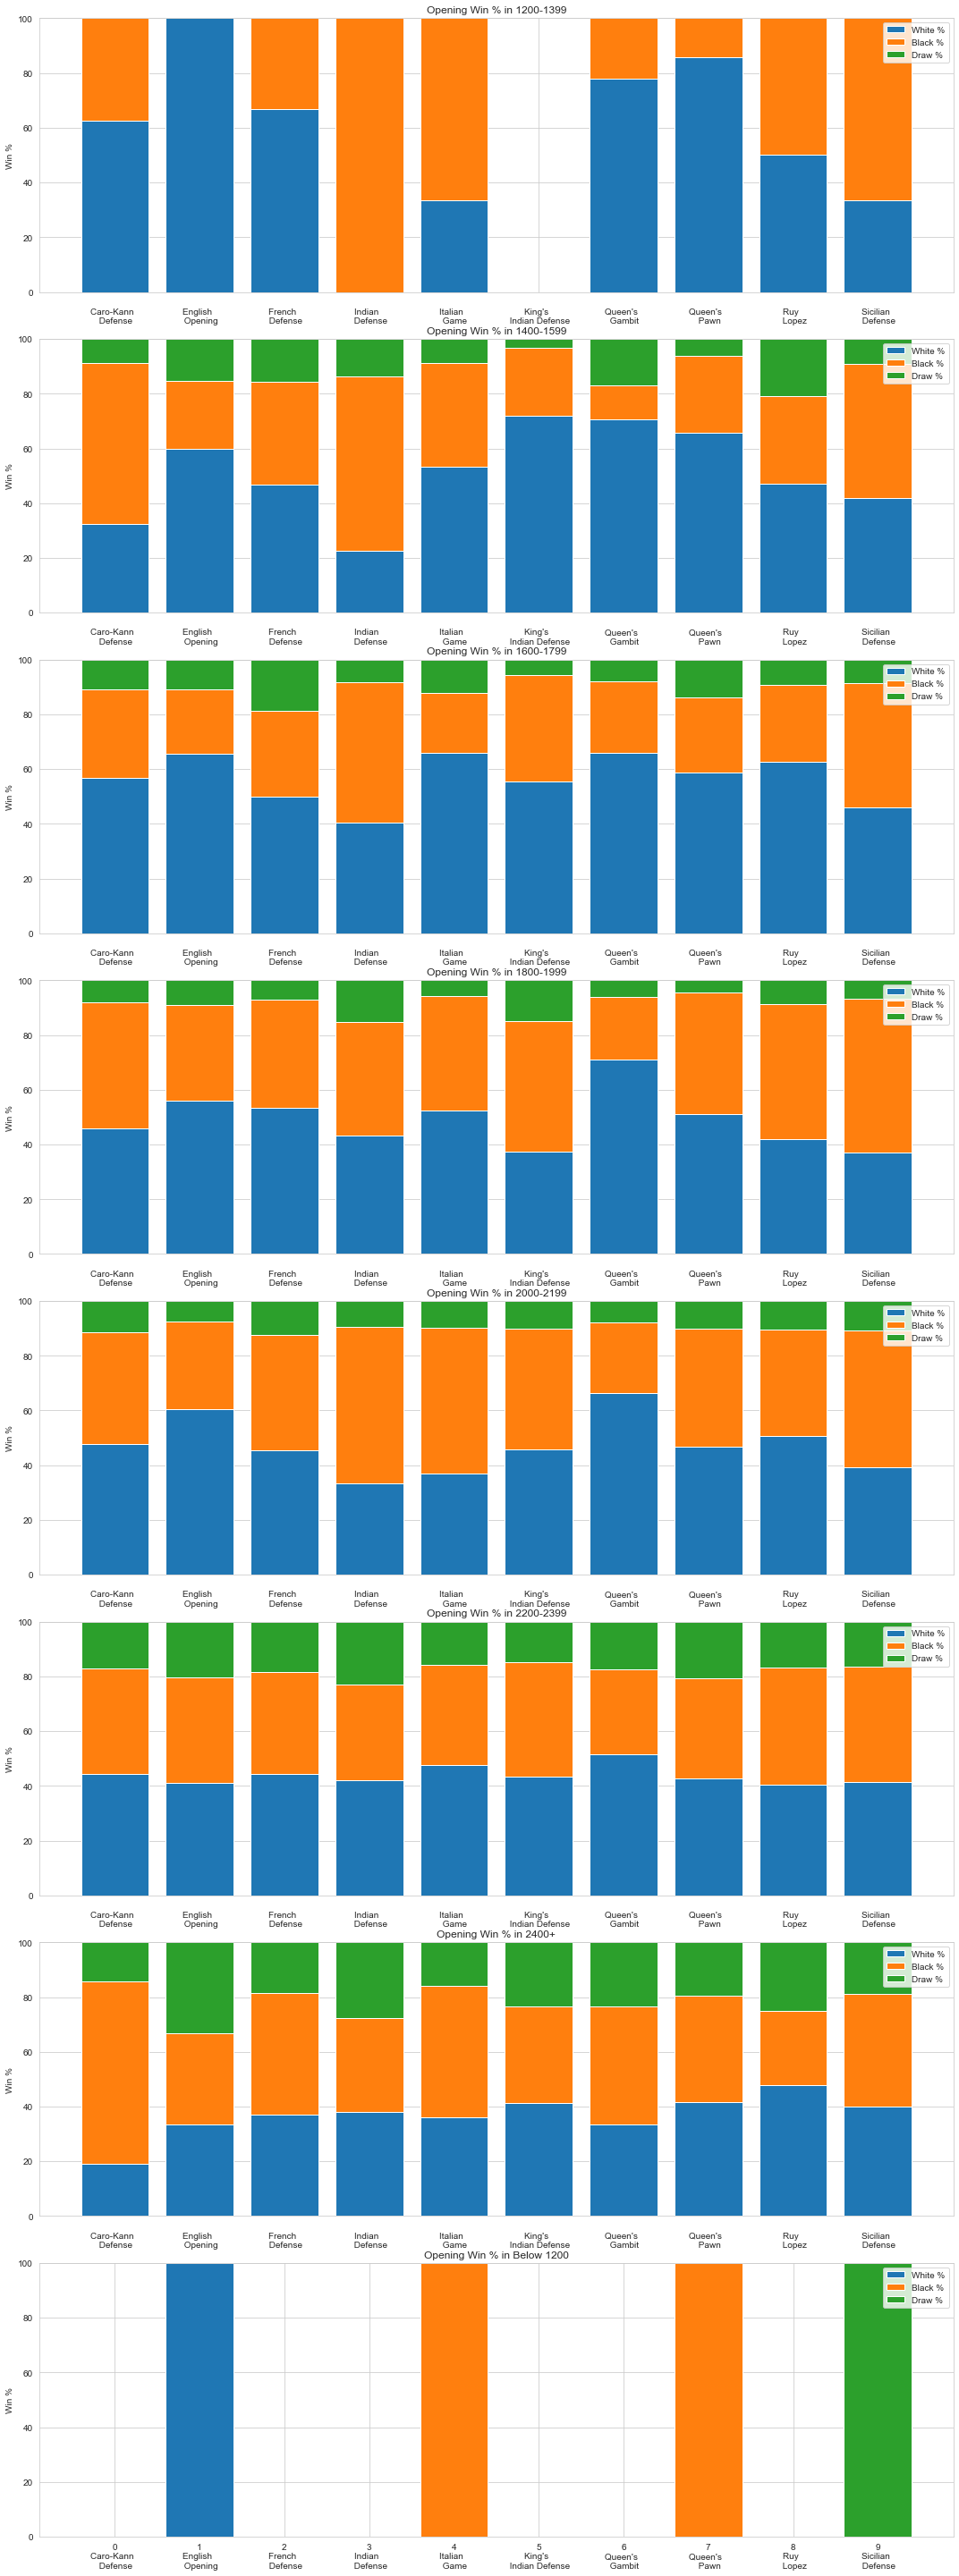

In [25]:
import seaborn as sns
# setup plot
sns.set_style('whitegrid')

# rating categories
rating_cats = sorted(df['rating_cat'].unique())

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
#shorthandsubplot
fig, axes = plt.subplots(len(rating_cats), 1, figsize=(15, 5 * len(rating_cats)), sharex=True)

if len(rating_cats) == 1: axes = [axes]  #iterate check ifpossible

# plot by category
for idx, rcat in enumerate(rating_cats):
    ax = axes[idx]
    data = alpha_pivot_df[alpha_pivot_df['rating_cat'] == rcat]
    
    if data.empty:  # check if data exists
        ax.text(0.5, 0.5, f'No data for {rcat}', ha='center', va='center')
        ax.axis('off')
        continue
        
    # check if the current rating category has data for all of the top openings; if not, add missing openings as empty rows
    for opening in top_openings: 
        if opening in data['clean_opening'].values:
            continue
        else:
            row_dict = {'rating_cat': [rcat], 'clean_opening': [opening], 'black': [0], 'white': [0], 'total_games': [0],
                      'white_win_pct': [0], 'black_win_pct': [0], 'draw_pct': [0]}
            new_row = pd.DataFrame.from_dict(row_dict)
            data = pd.concat([data, new_row], ignore_index = True)
            data = data.sort_values(['rating_cat', 'clean_opening'])
            
    
    # stacked bars
    bar_w = 0.8
    openings = data['clean_opening']
    openings = openings.apply(new_line)
    
    ind = np.arange(len(openings))
    
    ax.bar(ind, data['white_win_pct'], label='White %', color=colors[0], width=bar_w)
    ax.bar(ind, data['black_win_pct'], bottom=data['white_win_pct'], label='Black %', color=colors[1], width=bar_w)
    ax.bar(ind, data['draw_pct'], bottom=data['white_win_pct'] + data['black_win_pct'], label='Draw %', color=colors[2], width=bar_w)
    
    ax.set_ylabel('Win %')
    ax.set_ylim(0, 100)
    ax.set_title(f'Opening Win % in {rcat}')
    ax.set_xticks(ind)
    ax.legend(loc='upper right')
    
    # Add opening names below bars; single x ticks label unclear with so many plots
    for i, opening in enumerate(openings):
        ax.text(i, -12, opening, ha='center', va='bottom', fontsize=10)
        
plt.tight_layout()
plt.show()

#### Analysis ####

This plot produces a variety of interesting results. The Caro-Kann Defense appears to lead to approximately equal returns to black and white across skill levels, though notably white wins significantly more frequently when the game has a low average rating and black wins significantly more frequently when the game has a high average rating. The English Opening seems to produce reliably higher win rates for the white player, unless the game's average rating is above 2200, in which case the English Opening leads to a lot more draws and an approximately equal win rate between black and white. The French Defense seems to lead to more draws than most openings for games with a lower average rating. White seems to win more frequently when playing the French Defense in lower rated games, though the win rate evens out for higher rated games and black seemingl wins more freqently for the highest rated games with the French Defense. Lower rated games playing the Indian Defense mostly show a higher win rate for black, while the Indian Defense leads to a lot of draws and a fairly even split between black and white winners at higher levels. The Italian Game produces fairly mixed results, though it seems fair to say that lower and higher rated games see relatively higher win rates for black when playing the Italian Game, whereas mid-tier games tend to see stronger returns for the white player. The King's Indian Defense is never played by the lowest rated players in the dataset. For games with an average rating of 1400-1599, the King's Indian Defense leads to significantly higher win rates for the white player. However, for higher rated players, the win rate distribution evens out, with the opening also producing a fairly high draw rate in higher rated games. The Queen's Gambit seems to lead to high white win rates almost across the board, except for in the highest rated games, where it seems to have a relatively high draw rate and a better win rate for black than white. The Queen's Pawn opening leads to high win rates for the white player in lower rated games, although the distribution between black and white evens out for games rated higher than 1800, and it has high draw rates when played at the highest level. The Ruy Lopez opening leads to fairly even distributions between white and black win rates across the board, though with an edge for white in most rating categories, and relatively high draw rates. The Sicilian Defense also leads to fairly even distributions of win rates, although the figure suggests that black typically enjoys some level of edge across rating categories.

Aside from showcasing broad trends in opening success across game ratings, this visualization also provides an idea of which openings typically work best for which player for a game at a given average rating. The white player in a game with an average rating of 1200-1399 would likely want to play the English Opening, for example, while the black player would probably prefer to play the Indian Defense. For games in the 1400-1599 range, white should target the King's Indian Defense or the Queen's Gambit, while black would likely again prefer to play the Indian Defense. In games with a rating of 1600-1799, white would likely prefer to play the English Opening, Italian Game, or Queen's Gambit, whereas black would again prefer to play the Indian Defense. In 1800-1999 rated games, white's preference would likely be to play the Queen's Gambit, while black would prefer the Sicilian Defense. The same is true of 2000-2199 rated games, though black might also be comfortable with the Indian Defense. For games in the 2200-2399 range, white should likely attempt to play the Queen's Gambit, while black might prefer the English Opening, Ruy Lopez, or Sicilian Defense. In the highest rated games, white would likely be best served to play the Ruy Lopez opening, while black would seemingly strongly prefer to play the Caro-Kann Defense. This shows how the opening can lead to different results depending on the relative skill of the players in the game. 

### Viz 3: ###
The viz of the win rates by opening and skill level led to interest in the overall win rates for the white and black sides and the number of draws for the entire dataset, to see which color wins more often across all types of openings and rating levels. This third visualization builds a barplot for the percentage of white wins, black wins, and draws. It was hypothesized that white would have a slight advantage because it moves first resulting in a higher win rate.

#### Data Manipulation ####

In [26]:
# calculate win percentages for the entire dataset, including all games
total_games = df['winner'].count()
white_wins = df['winner'][df['winner'] == 'white'].count()
black_wins = df['winner'][df['winner'] == 'black'].count()
draw = df['winner'][df['winner'] == 'draw'].count()

# build a dataframe with the win percentages for easy plotting
win_perc = pd.DataFrame({
    'winner': ['white', 'black', 'draw'],
    'percentage (%)': [round(white_wins/total_games * 100, 2), 
                   round(black_wins/total_games * 100, 2), 
                   round(draw/total_games * 100, 2)]})

win_perc

,winner,percentage (%)
0,white,46.73
1,black,40.13
2,draw,13.14


#### Plot creation: 

In [27]:
# build the plot
fig = px.bar(win_perc, x='winner', y='percentage (%)', 
             title='Win Percentage by Winner', 
             labels={'winner': 'Winner', 'percentage': 'Win Percentage (%)'},
             color='winner', color_discrete_map={'white':'blue', 'black':'orange', 'draw':'green'})

# Show the plot
fig.show()

#### Analysis ####
As hypothesized, white has a higher win percentage (46.73%) than black (40.13%). This makes sense given that white's first move is crucial to determining what the opening will be, which means they (in theory) can set the game to their advantage from the beginning. The rate of draws (13.14) was higher than expected. This all suggests that color will be a valuable part of determining which player is likely to win a given game. 

### Viz 4/5: ###

We also wanted to look at whether the rating differential in a game (eg, the difference between the winner's rating and the loser's rating) seemed to have an impact on the outcome of the match. We built the rating differential column in the dataframe such that it shows (winner's rating - loser's rating), so a negative rating differential value shows that the lower rated player in the game won, while a positive rating differential shows that the better-rated player won. We suspected that we would see a histogram with some left skewness, because it seems likely that the better-rated player would win more often than not. 

#### Entire dataset ####
##### Data Manipulation: #####

In [28]:
# build a new dataframe that only includes the openings we are analyzing and that excludes games that draw (NaN value for rating diff)
df_no_draw = df_top_openings[df_top_openings['winner'] != 'draw']

##### Visualization: #####

number of matches in each bin: [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 2.000e+00 7.000e+00 1.200e+01 7.000e+00 3.400e+01 3.100e+01 7.800e+01
 7.600e+01 1.090e+02 1.950e+02 3.720e+02 6.250e+02 1.489e+03 1.100e+03
 8.900e+02 6.380e+02 5.570e+02 4.140e+02 2.760e+02 2.290e+02 1.520e+02
 9.700e+01 9.500e+01 5.600e+01 3.000e+01 1.900e+01 1.400e+01 7.000e+00
 1.000e+00 2.000e+00 1.000e+00 1.000e+00]


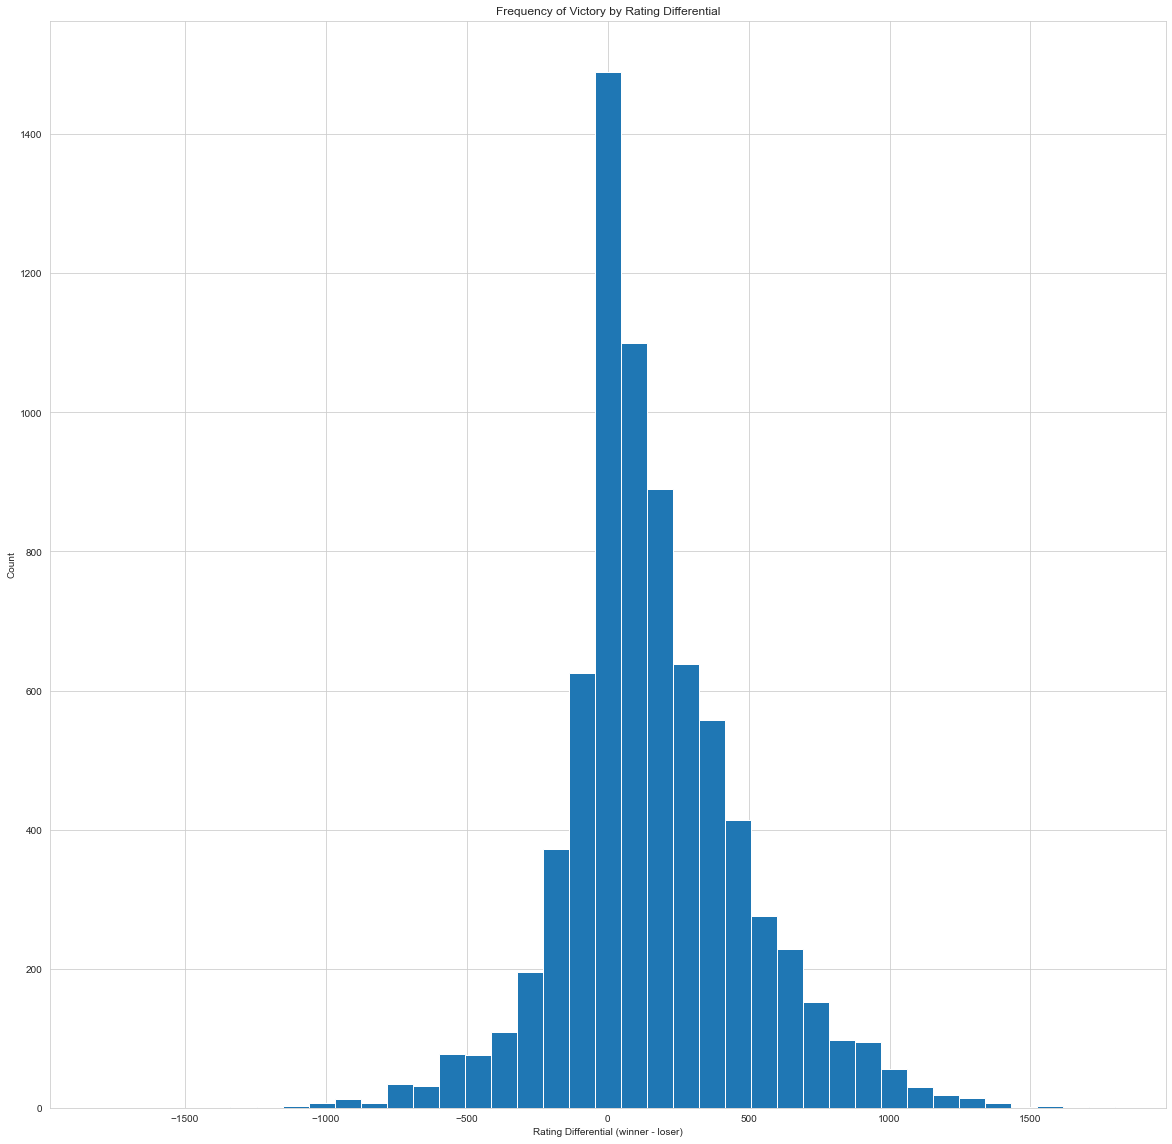

In [29]:
# set the bins based on the range of the data
binss = np.linspace(-1800, 1800, 40)

# build the plot, storing the count in each bin and the boundaries of the bins
counts, bins, patches = plt.hist(df_no_draw['rating_diff'], bins = binss);

# print the number of matches in each bin to show the tails are longer than they appear
print('number of matches in each bin:', counts)

# clean up the viz and show the plot
plt.gcf().set_size_inches(20, 20)
plt.title('Frequency of Victory by Rating Differential')
plt.xlabel('Rating Differential (winner - loser)')
plt.ylabel('Count')
plt.show()

#### Subplots by rating category ####

##### Helper function: #####

In [30]:
def plot_hist(df, col, subplot_col):
    ''' Creates subplots of histograms for a dataframe and a given column based on categories from another given column 
    Args:
        df (dataframe) = dataframe
        col (string) = column name
        subplot_col (string) = name of the column from the df that has the categories for the subplots
        
    Returns:
        Subplots of histograms
    '''
    # create list of categories for the subplots
    subplot_lst = df[subplot_col].unique().tolist()
    
    for item in subplot_lst:
         # activate a specific subplot (use .index() to find the numeric index for the current string)
        item_idx = subplot_lst.index(item)
    
        #generate the subplot and plot the histograms
        plt.subplot(2, 4, item_idx + 1)
        plt.hist(df[df[subplot_col] == item][col], bins = 'auto')
        plt.gca().title.set_text(f'Rating range: {subplot_lst[item_idx]}')
        plt.xlabel(col, size = 8)
        if item_idx == 0:
            plt.ylabel('Count')
            
        # adjust subpot size and spacing
        plt.subplots_adjust(wspace=.5, hspace=0.5)
        plt.gcf().set_size_inches(20,10)

##### Visualization: #####

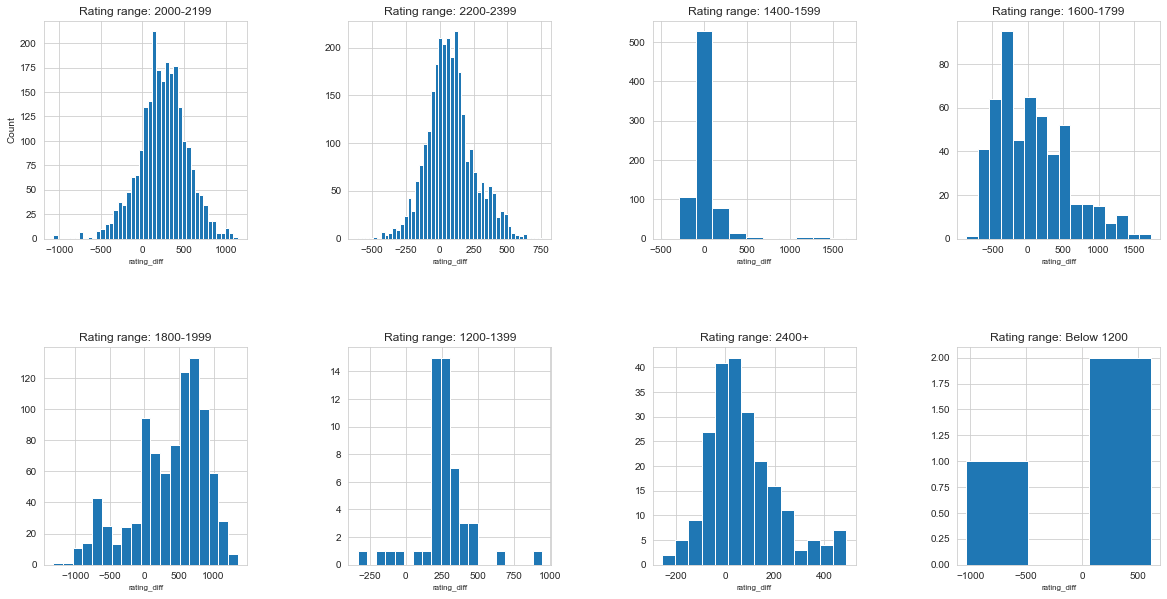

In [31]:
plot_hist(df_no_draw, 'rating_diff','rating_cat')

#### Analysis of Histograms ####
Positive rating_diff values indicate the player with higher rating won while negative rating_diff values indicate the player with the lower rating won or the match resulted in a draw. As expected, the histogram for the entire dataset resembles a normal distribution but is shifted more towards the positive rating differentials, suggesting the higher rated player indeed tends to win more. In examining the subplots based on rating category, we can draw some interesting conclusions. For games rated between 1800 and 2399, the histograms all seem to be centered fairly significantly above 0. This suggests that these types of games tend to be played between players with more unbalanced ratings more frequently, and that in those games, the higher rated player indeed wins most often. The same is true for games rated between 1200 and 1399. However, for games rated between 1400 and 1799, and for games rated over 2400, the histograms are centered around 0 or slightly skewed right. They still have longer tails to the right, which indicates that the higher rated player tends to win more, but it seems likely that these types of games are more frequently between players of similar ratings. Conclusions for games with average ratings below 1200 cannot be made due to the low number of games in the data. Overall, it is clear from these visualizations that relative ratings do indeed matter in determining who will win, and should have a fairly significant weight in our ultimate model. 

### Viz 6 ###

We also wanted to see whether there was any relation between a game's move count and the skill gap between its players. The thought here was that it seems reasonable to suspect that unbalanced games would be short, with the better player overpowering the worse player quickly or the worse player getting lucky and winning quickly, while more even games would take more moves. 

#### Plot construction: ####

In [32]:
import plotly.express as px

# group the dataframe with the openings we want to analyze by openings
clean_opening_groups = df_top_openings.groupby('clean_opening')

# iterate over top openings, pull group of rows associated with each opening, build scatter for each one
for item in top_openings: 
    grouped_df = clean_opening_groups.get_group(item)
    figure = px.scatter(grouped_df, x = 'rating_diff', y = 'move_count', color = 'winner', title = f'{item}')
    figure.show()

#### Analysis ####

Our hypothesis seems as though it may be correct for some openings, but not for others. It seems fairly clear that the Sicilian Defense, English Opening, French Defense, Ruy Lopez, and Italian Game tend to be won relatively quickly by the better player, and that the games tend to be longer when there is more parity between the players. The other openings have scatters that appear more random, suggesting that skill gap and length of game may be somewhat unrelated for those openings. Additionally, the plot for the King's Indian Defense is interesting in that it seems to show a particular low amount of upsets. 

### Viz 7 ###

Similarly to visualization 6, we also wanted to see whether there was any relation between a game's move count and its average rating for a given opening. It was hypothesized that higher-rated games would last longer due to the players being more familiar with the theory and tactics of chess.

#### Plot construction: ####

In [33]:
for item in top_openings: 
    grouped_df = clean_opening_groups.get_group(item)
    figure = px.scatter(grouped_df, x = 'avg_rating', y = 'move_count', labels = {'move_count': 'Move Count', 'avg_rating': 'Average Game Rating'}, title = f'{item}')
    mean = grouped_df.groupby(['clean_opening'])['move_count'].mean()
    # providing the mean move count for given opening
    print(round(mean,2))
    figure.show()

clean_opening
Sicilian Defense    73.8
Name: move_count, dtype: float64


clean_opening
English Opening    76.57
Name: move_count, dtype: float64


clean_opening
Caro-Kann Defense    73.65
Name: move_count, dtype: float64


clean_opening
French Defense    72.45
Name: move_count, dtype: float64


clean_opening
Queen's Pawn    74.36
Name: move_count, dtype: float64


clean_opening
Queen's Gambit    72.18
Name: move_count, dtype: float64


clean_opening
Italian Game    70.84
Name: move_count, dtype: float64


clean_opening
Indian Defense    74.98
Name: move_count, dtype: float64


clean_opening
Ruy Lopez    76.19
Name: move_count, dtype: float64


clean_opening
King's Indian Defense    78.01
Name: move_count, dtype: float64


#### Alternative Viz 7 ####
Utilizing Plotly's feature that allows toggling of specific groups of data, the entire dataset for the top 10 openings was plotted onto 1 scatter plot to get an overall view of the relationship between move count and average rating. Closer inspection of specific openings can be toggled using Plotly's feature in the legend.

In [34]:
figure = px.scatter(df_top_openings, x = 'avg_rating', y = 'move_count', color = 'clean_opening', 
                    labels = {'move_count': 'Move Count', 'avg_rating': 'Average Game Rating'}, title = 'Move Count vs Average Game Rating')
figure.show()

In [36]:
df_top_openings['winner'].unique()

array(['white', 'black', 'draw'], dtype=object)

In [77]:
df_new = df_top_openings.copy()
df_new = df_new.dropna()

df_copy = df_new.copy()
dummy_df1 = pd.get_dummies(df_copy, columns = ['clean_opening'], drop_first = True)

# standardize the black ratings and white ratings
for feat in ['white_rating', 'black_rating', 'rating_diff']:
    df_new[f'{feat}_scaled'] = (df_new[feat] - df[feat].mean()) / df_new[feat].std()
    
dummy_df = pd.get_dummies(df_new, columns = ['clean_opening'], drop_first = True)
    
reg_df = dummy_df.drop(dummy_df.columns[0:13], axis = 1)

reg_df = reg_df.dropna()

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d  with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

def line_of_best_fit(X, y):
    """ calculates the coefficients for the line of best fit for a set of data
    Args:
        X (array): can be either 1-d or 2-d
        y (array): 1-d array including all corresponding response values to X
        
    Returns:
        m (vector): contains coefficients for line of best fit 
    """
    #add the bias column to X
    Xnew = add_bias_column(X)
    
    # Inverse of Xnew.transpose * Xnew
    XtXinv = np.linalg.inv(np.matmul(Xnew.T, Xnew))
    
    # Xnew.transpose * y 
    Xty = np.matmul(Xnew.T, y)
    
    # [(XtX)^-1]Xty to get the vector w/ coefficients for line of best fit
    # m = [intercept, slope]
    m = np.matmul(XtXinv, Xty)
    return m

def linreg_predict(Xnew, ynew, m):
    """ calculates the predicted y values using the coefficients of the line of best fit for the data.
    calculates the residuals, mse, and r^2 between the predicted and actual y values.
    Args:
        Xnew (array): an array, either 1-d or 2-d which includes all the predictor features, not including bias term
        ynew (array): a 1-d array which includes all corresponding response values to Xnew
        m (vector): a 1-d array of length p+1 which contains the coefficients from the line_of_best_fit function
        
    Returns:
        linreg_dict (dictionary): dictionary containing key value pairs: ypreds, resids, mse, r2
    """
    Xnew = add_bias_column(Xnew)
    
    #calculating the predicted y values using the coefficients from line_of_best_fit
    ypreds = np.matmul(Xnew, m)

    #calculating residuals
    resids = ynew - ypreds

    #calculating mean square error (mse)
    sum_resids = 0
    for item in resids:
        sum_resids += item**2  
    mse = sum_resids/len(resids)

    #calculating r^2 value
    r2 = r2_score(ynew, ypreds)
    
    # Creating dictionary
    linreg_dict = {'ypreds' : ypreds,
                   'resids' : resids,
                   'mse' : mse,
                   'r2' : r2}
    return linreg_dict

In [114]:
# build the X and y arrays using the scaled x values and the y values
X = reg_df.values
y = df_new['move_count'].values

In [115]:
print(X.shape)
print(y.shape)

(7617, 12)
(7617,)


In [116]:
fitted_model = line_of_best_fit(X, y)

linreg_dict = linreg_predict(X,y,fitted_model)

fitted_model

resids = linreg_dict['resids']
mse = linreg_dict['mse']
r2 = linreg_dict['r2']
print(f'MSE: {mse}')
print(f'R^2: {r2}')

MSE: 1085.6779965319197
R^2: 0.0522246324234491


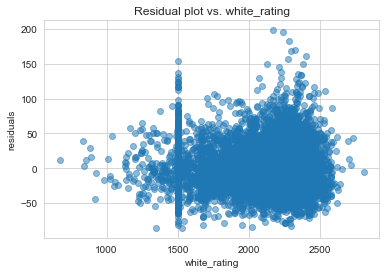

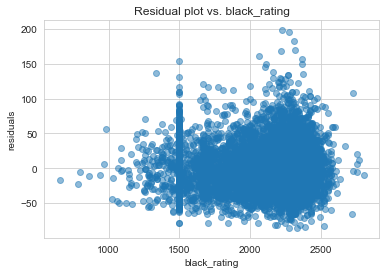

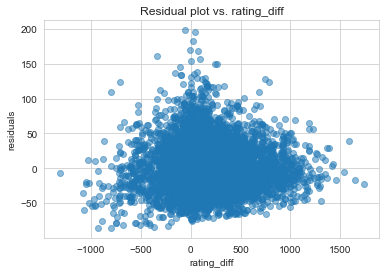

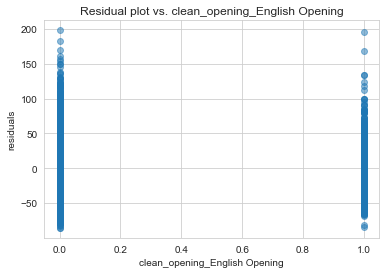

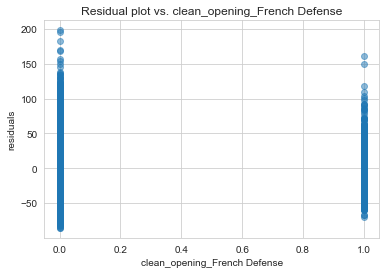

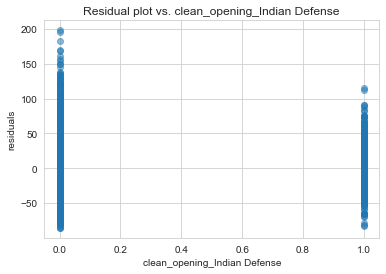

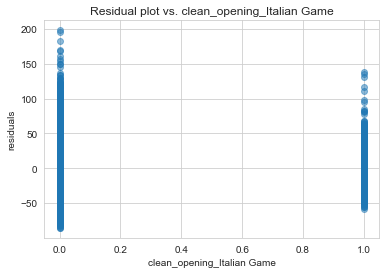

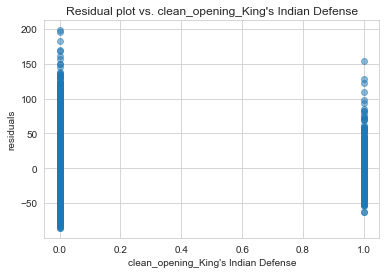

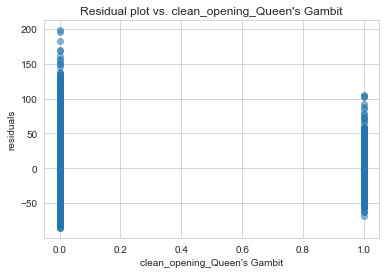

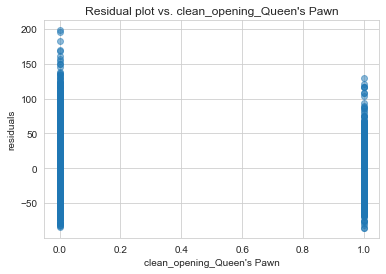

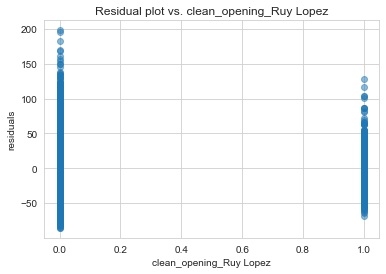

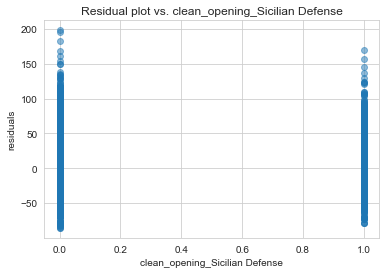

In [117]:
x_feat_list = ['white_rating', 'black_rating', 'rating_diff', 'clean_opening_English Opening', 'clean_opening_French Defense', 'clean_opening_Indian Defense', 'clean_opening_Italian Game', "clean_opening_King's Indian Defense", "clean_opening_Queen's Gambit", "clean_opening_Queen's Pawn", 'clean_opening_Ruy Lopez', 'clean_opening_Sicilian Defense']

# iterate over the list of x features
for col in x_feat_list: 
    
    # plot the current x feature vs the residuals
    plt.scatter(dummy_df1.loc[:,col], linreg_dict['resids'], alpha = 0.5)
    plt.xlabel(col)
    plt.ylabel('residuals')
    plt.title(f'Residual plot vs. {col}')
    plt.show()

In [105]:
# build the X and y arrays using the scaled x values and the y values
X = df_new['rating_diff'].values
y = df_new['move_count'].values

In [106]:
fitted_model = line_of_best_fit(X, y)

linreg_dict = linreg_predict(X,y,fitted_model)

fitted_model

resids = linreg_dict['resids']
mse = linreg_dict['mse']
r2 = linreg_dict['r2']
print(f'MSE: {mse}')
print(f'R^2: {r2}')

MSE: 1113.6321573390053
R^2: 0.02782120422571599


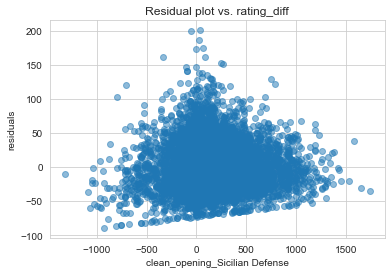

In [107]:
plt.scatter(df_new['rating_diff'], linreg_dict['resids'], alpha = 0.5)
plt.xlabel(col)
plt.ylabel('residuals')
plt.title(f'Residual plot vs. rating_diff')
plt.show()

In [98]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias = False)
X_poly = poly.fit_transform(np.array(X).reshape(-1,1))

In [99]:
#calculating coefficients to line of best fit
m_full = line_of_best_fit(X_poly, y)

#running predictions
linreg_dict = linreg_predict(X_poly, y, m_full)

mse = linreg_dict["mse"]
r2 = linreg_dict['r2']
resids = linreg_dict['resids']
print(f'MSE: {mse}')
print(f'R^2: {r2}')

MSE: 1104.0732455325901
R^2: 0.03616594472879042
